In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize

%matplotlib inline

## 1. Logistic Regression
In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university.

Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant's scores on two exams and the admissions decision.

Your task is to build a classification model that estimates an applicant's probability of admission based the scores from those two exams.

In [25]:
data = np.loadtxt('machine-learning-ex2/ex2/ex2data1.txt', delimiter=",")
X, y = data[:, :2], data[:, 2]

In [27]:
print(X.shape)
print(y.shape)

(100, 2)
(100,)


### 1.1 Visualizing the data

Before starting to implement any learning algorithm, it is always good to visualize the data if possible. Display a figure where the axes are the two exam scores, and the positive and negative examples are shown with dierent markers.

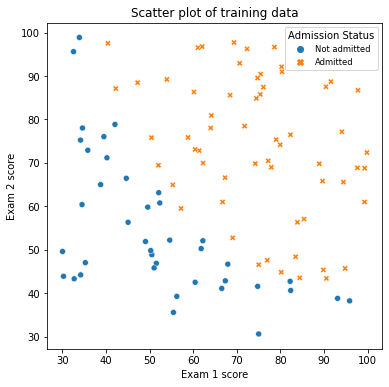

In [28]:
# Change the y values for plotting
y_labels = np.where(y < 1, "Not admitted", "Admitted")

# Create the scatter plot using seaborn and matplotlib to change the figure size and legend
fig1, ax1 = plt.subplots(figsize=(6,6))

scatter = sns.scatterplot(ax=ax1, x=X[:,0], y=X[:,1], style=y_labels, hue=y_labels, cmap='bright')
scatter.set(title="Scatter plot of training data", xlabel="Exam 1 score", ylabel = "Exam 2 score")

ax1.legend(title='Admission Status', loc='upper right', fontsize='small')
pass


### 1.2 Implementation

In [63]:
# Add an X0 for every sample for gradient descenet
X_grad = np.hstack((np.ones((X.shape[0], 1)), X))

In [66]:
# Set the initial theta parameters
theta = np.zeros(X_grad.shape[1])

In [67]:
# Set the learning rate and number of iterations
alpha = 0.004
iters = 1000000

#### 1.2.1 Sigmoid Function

In [68]:
# Define a sigmoid function implementation
def sigmoid(x):
    
    return 1/(1+np.exp(-x))

In [69]:
# Test sigmoid function
sigmoid(0)

0.5

#### 1.2.2 Logistic Regression Cost Function (unregularized)

In [70]:
# Define the cost function
def cost_function(X, y, theta):
    
    hypothesis = sigmoid(X.dot(theta.T))
    to_sum = -y.dot(np.log(hypothesis)) - (1-y).dot(np.log(1-hypothesis))
    return np.sum(to_sum)/len(y)

#### 1.2.3 Logistic Regression Batch Gradient Descent (unregularized)

In [71]:
# Define the gradient descent function

def gradient_descent(X, y, theta, alpha, iterations):
        
    thetas = []
        
    for i in range(iterations):  
                
        # Find the hypothesis function via cross product of X and theta tranposed
        hypothesis = sigmoid(X.dot(theta.T))
                
        # Calculate the value of the derivative of the cost function with regularization
        cost_derivative = (hypothesis-y).dot(X)
                
        # Simultaneously update the theta parameter vector
        theta = theta - ((alpha/len(y))*cost_derivative)
        thetas.append(theta)
    
    return thetas

In [72]:
# Check the cost function when theta is set to 0
cost_function(X_grad, y, theta)

0.6931471805599452

In [73]:
# Run gradient descent
thetas = gradient_descent(X_grad, y, theta, alpha, iters)
final_theta = thetas[-1]
final_theta

array([-24.70897924,   0.20261361,   0.19781124])

In [74]:
# Print the final cost
cost_function(X_grad, y, final_theta)

0.20352860774642934

#### 1.2.4 Evaluate Logistic Regression

Now we can plot the decision boundary using the final theta parameters.

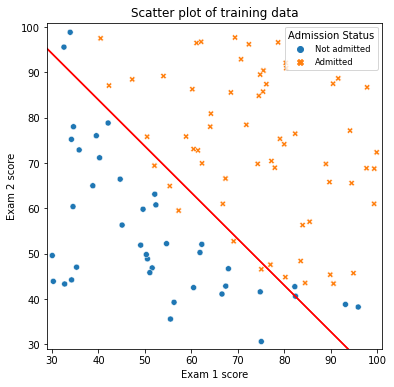

In [75]:
# Create a decision boundary on top of the old scatter plot

# When y = 1, z >= 0, and when y = 0, z <= 0, so the decision boundary is at z = 0
# ===> theta_0*x_0 + theta_1*x_1 + theta_2*x_2 = 0
x1 = np.linspace(0,100,71)
x2 = (-final_theta[0] - final_theta[1]*x1)/final_theta[2]

# Plot the decision boundary on top of the scatter plot
ax1.plot(x1, x2, 'r', label="Decision boundary")
ax1.set_xlim(29, 101)
ax1.set_ylim(29, 101)

# Show the figure
fig1


In [76]:
# Predict the classes of the samples
hypothesis = sigmoid(np.matmul(X_grad, final_theta.T))
predicted = np.where(hypothesis >= 0.5, 1, 0)
correct = (y==predicted).astype(int)

# Evaluate the training accuracy
print(f"Total prediction accuracy: {np.sum(correct)/correct.size*100}%" )

Total prediction accuracy: 89.0%


## 2. Regularized Logistic Regression

In this part of the exercise, you will implement regularized logistic regression
to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure
it is functioning correctly. Suppose you are the product manager of the factory and you have the
test results for some microchips on two different tests. From these two tests,
you would like to determine whether the microchips should be accepted or
rejected.

In [77]:
data = np.loadtxt('machine-learning-ex2/ex2/ex2data2.txt', delimiter=",")
X1, y1 = data[:, :2], data[:, 2]

In [78]:
print(X1.shape)
print(y1.shape)

(118, 2)
(118,)


### 2.1 Visualizing the data

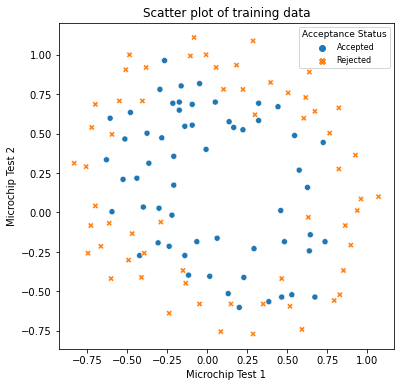

In [79]:
# Change the y values for plotting
y1_labels = np.where(y1 < 1, "Rejected", "Accepted")

# Create the scatter plot using seaborn and matplotlib to change the figure size and legend
fig2, ax2 = plt.subplots(figsize=(6,6))

scatter = sns.scatterplot(ax=ax2, x=X1[:,0], y=X1[:,1], style=y1_labels, hue=y1_labels, cmap='bright')
scatter.set(title="Scatter plot of training data", xlabel="Microchip Test 1", ylabel = "Microchip Test 2")

legend = plt.legend(title='Acceptance Status', loc='upper right', fontsize=8)
legend.get_title().set_fontsize(9)
plt.show()
pass

### 2.2 Feature mapping

One way to fit the data better is to create more features from each data
point. We will map the features into
all polynomial terms of x1 and x2 up to the sixth power.

In [80]:
# Define the function to map features of X0 and X1 up to some polynomial degree

def map_features(X, deg=2):
    
    # Initialize the output with ones
    out = np.ones((X.shape[0], 1))
    
    for i in range(1, deg+1):
        for j in range(0, i+1):
            out = np.hstack((out,(np.power(X[:,0], i-j)*np.power(X[:,1], j)).reshape(-1,1)))
    
    return out

# Map up to combinations of degree 6
X1_mapped = map_features(X1, deg=6)

While the feature mapping allows us to build a more expressive classifier, it is also more susceptible to overfitting. Next, implement regularized logistic regression to fit the data and also see how regularization can help combat the overfitting problem.

### 2.3 Regularized Cost Function and Gradient Descent

#### 2.3.1 Regularized Cost Function

In [81]:
# Define the regularized cost function
def reg_cost_function(theta, X, y, lamda):

    # Set theta_0 to zero so it does not get regularized
    temp = theta
    temp[0] = 0
    
    # Normal cost function without regularization
    hypothesis = sigmoid(X.dot(theta.T))
    non_reg = np.sum(-y.dot(np.log(hypothesis)) - (1-y).dot(np.log(1-hypothesis)))
    
    # Regularization
    reg = (lamda/2)*np.sum(np.power(temp,2))
        
    return (non_reg + reg)/len(y)

In [82]:
# Create a corresponding theta vector for the mapped feature vector
theta1 = np.zeros(X1_mapped.shape[1])

# Set lambda
lam = 1

# Check the cost function when theta is set to 0
reg_cost_function(theta1, X1_mapped, y1, lam)

0.6931471805599454

#### 2.3.2 Regularized Gradient Descent

In [83]:
# Define the regularized gradient descent function

def reg_gradient_descent(X, y, theta, lamda, alpha, iterations):
        
    thetas = []
    
    for i in range(iterations):  
        
        # Find the hypothesis function via dot product of X and theta tranposed
        hypothesis = sigmoid(X.dot(theta.T))
        
        # Set a temp theta to leave theta_0 unregularizaed
        temp_theta = theta
        temp_theta[0] = 0
                
        # Calculate the value of the derivative of the cost function with regularization
        cost_derivative = (hypothesis-y).dot(X) + lamda*temp_theta
        
        # Simultaneously update the theta parameter vector
        theta = theta - ((alpha/len(y))*cost_derivative)
        thetas.append(theta)
        
    return thetas

In [84]:
# Create a corresponding theta vector for the mapped feature vector
theta1 = np.zeros(X1_mapped.shape[1])

# Set the learning rate and number of iterations
alpha1 = 0.01
iters1 = 100000
lam = 1

# Run gradient descent
thetas1 = reg_gradient_descent(X1_mapped, y1, theta1, lam, alpha1, iters1)
final_theta1 = thetas1[-1]
final_theta1

array([ 9.93253572e-04,  3.93791480e-01,  1.07868223e+00, -5.67552648e-01,
       -9.11170423e-01,  1.73110710e-01,  1.54335399e-01, -4.09960158e-01,
       -2.39238038e-01, -1.73358373e-01, -1.13819317e+00, -2.96337923e-02,
       -5.39266928e-01, -2.21339319e-01, -9.23197152e-01, -2.54741454e-01,
       -2.23816717e-01, -3.15062673e-02, -3.11321761e-01, -2.12233751e-01,
       -6.04454289e-01, -9.87465921e-01,  4.04702215e-02, -3.00636377e-01,
        3.27127651e-02, -3.51713147e-01, -8.44626323e-02, -1.02213013e+00])

Next, we use an optimizer function to return the best values of theta. We will define a new combined cost and gradient function to pass into the optimizer.

In [85]:
# Create a combined cost and gradient function without gradient descent so that we can 
# use the optimizer from scipy to find the thetas using the Truncated Newton method

def reg_costandgrad(theta, X, y, lamda):
    
    # Hypothesis function
    hypothesis = sigmoid(X.dot(theta.T))
        
    # Set theta_0 to zero so it does not get regularized
    temp = theta
    temp[0] = 0
    
    # Normal cost function without regularization
    non_reg = np.sum(-y.dot(np.log(hypothesis)) - (1-y).dot(np.log(1-hypothesis)))
    
    # Regularization
    reg = (lamda/2)*np.sum(np.power(temp,2))
     
    # Cost function
    J = (non_reg + reg)/len(y)

    # Calculate the value of the derivative of the cost function with regularization
    cost_derivative = (hypothesis-y).dot(X) + lamda*temp

    # Simultaneously update the theta parameter vector to return the gradient
    grad = (1/len(y))*cost_derivative
    
    return J, grad

In [88]:
# Initialize the theta vector
initial_theta = np.zeros(X1_mapped.shape[1])

# Set regularization parameter
lam = 1

# Set the options for optimize.minimize to max 100 iterations
options= {'maxiter': 100}

# Run the optimizer to find the theta vector that minimizes the cost function
res = optimize.minimize(reg_costandgrad, initial_theta, (X1_mapped, y1, lam), jac = True, options=options)

# the fun property of OptimizeResult object returns the value of costFunction at optimized theta
cost = res.fun
print("Cost function at optimized theta:", cost)

# the optimized theta vector is in the x property of the result
optimized_thetas = res.x
print("Optimated theta array:\n", optimized_thetas)

Cost function at optimized theta: 0.5290027422869218
Optimated theta array:
 [ 1.27268739  0.62557016  1.1809665  -2.01919822 -0.91761468 -1.43194199
  0.12375921 -0.36513086 -0.35703388 -0.17485805 -1.45843772 -0.05129676
 -0.61603963 -0.2746414  -1.19282569 -0.24270336 -0.20570022 -0.04499768
 -0.27782709 -0.29525851 -0.45613294 -1.04377851  0.02762813 -0.29265642
  0.01543393 -0.32759318 -0.14389199 -0.92460119]


### 2.4 Plotting the decision boundary

In [89]:
# Plot the decision boundary

def plot_decision_boundary(u, v, theta, ax):

    z = np.zeros((u.size,v.size))
    
    for i in range(len(u)):
        for j in range(len(v)):
            mapped = map_features(np.array([[u[i], v[j]]]), 6)
            z[i, j] = np.dot(mapped, theta)
            
    z = z.T
    
    ax.contour(u, v, z, levels=[0], linewidths=1, colors='g')
    ax.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap='binary', alpha=0.1)


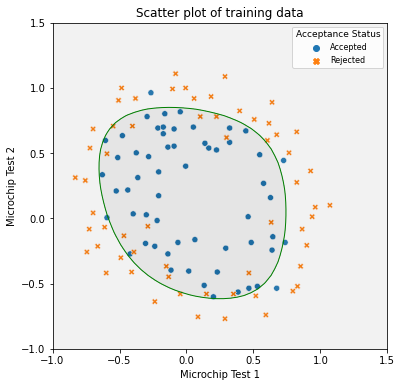

In [90]:
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)

plot_decision_boundary(u, v, optimized_thetas, ax2)

fig2

### 2.5 Varying Regularization Size

With a small lambda, the classifier gets almost every training example correct, but draws a very complicated boundary, thus overfitting the data. With a larger lambda, the classifer produces a simpler decision boundary which still separates the positives and negatives fairly well without overfitting. However, if lambda is set too high, the decision boundary will not follow the data well and will result in underfitting of the data.

In [91]:
# Set the list regularization parameters
lambdas = [0, 1, 100]

# Initialize the list of optimal thetas per lambda value
opt_thetas = []

# Run an optimizer for each value of lambda
for lam in lambdas:
    opt_thetas.append(optimize.minimize(reg_costandgrad, initial_theta, 
                                      (X1_mapped, y1, lam), jac = True, options=options).x)

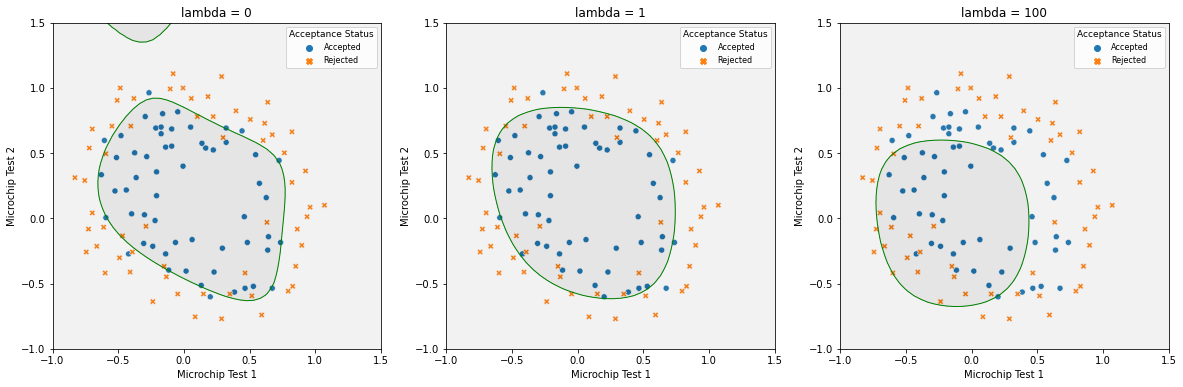

In [92]:
# Create three subplots for each value of lambda (regularization parameter)
fig3, ax3 = plt.subplots(1, 3, figsize=(20,6))

# For each lambda, create the decision boundary plot using the returned theta vector
for ax, lam, thetas in zip(ax3, lambdas, opt_thetas):
    
    scatter = sns.scatterplot(ax=ax, x=X1[:,0], y=X1[:,1], style=y1_labels, hue=y1_labels, cmap='bright')
    scatter.set(title=f"lambda = {lam}", xlabel="Microchip Test 1", ylabel = "Microchip Test 2")

    legend = ax.legend(title='Acceptance Status', loc='upper right', fontsize=8)
    legend.get_title().set_fontsize(9)
    
    plot_decision_boundary(u, v, thetas, ax)


In [93]:
# Predict the classes of the samples
for theta, lam in zip(opt_thetas, lambdas):
    hypothesis = sigmoid(X1_mapped.dot(theta.T))
    predicted = np.where(hypothesis >= 0.5, 1, 0)
    correct = (y1==predicted).astype(int)

    # Evaluate the training accuracy
    print(f"Total prediction accuracy score when lambda = {lam}: {np.sum(correct)/correct.size*100}%")
    print()


Total prediction accuracy score when lambda = 0: 83.05084745762711%

Total prediction accuracy score when lambda = 1: 83.05084745762711%

Total prediction accuracy score when lambda = 100: 61.016949152542374%

